In [58]:
# Zelle 1: Importieren der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score


In [59]:
# Zelle 2: Laden und Anzeigen des Datensatzes
# Laden des Datensatzes
df = pd.read_csv('Procrastination_and_Academic_Performance.csv')

# Überblick über den Datensatz
print("Datensatz-Überblick:")
print(f"Anzahl der Datenpunkte: {df.shape[0]}")
print(f"Anzahl der Variablen: {df.shape[1]}")

# Anzeigen der ersten Zeilen
print("\nErste 5 Zeilen:")
print(df.head())

# Datentypen und fehlende Werte
print("\nDatentypen und fehlende Werte:")
print(df.info())


Datensatz-Überblick:
Anzahl der Datenpunkte: 451
Anzahl der Variablen: 17

Erste 5 Zeilen:
            Timestamp   study_year socio-economic_background  \
0   11/4/2024 9:39:00  Fourth Year                    Middle   
1  11/4/2024 11:11:00   Third Year                    Middle   
2  11/4/2024 11:44:00  Second Year              Lower-middle   
3  11/4/2024 12:05:00  Fourth Year                      High   
4  11/4/2024 12:48:00   Third Year              Upper-middle   

  assignment_delay_frequency  \
0                     Always   
1                      Often   
2               Occasionally   
3                     Always   
4                  Sometimes   

                             procrastination_reasons  \
0                    Lack of interest, Health issues   
1  Procrastination due to lack of resources, Heal...   
2   Distractions (e.g., social media), Health issues   
3  Procrastination due to lack of resources, Heal...   
4                                   Lack of interes

In [60]:
# Zelle 3: Datenvorverarbeitung - Feature-Selektion und Zielvariable
# Ausgewählte Features
selected_features = [
    'study_year',
    'assignment_delay_frequency',
    'procrastination_reasons',
    'last_minute_exam_preparation',
    'study_hours_per_week',
    'use_of_time_management',
    'procrastination_management_training',
    'procrastination_recovery_strategies',
    'hours_spent_on_mobile_non_academic',
    'study_session_distractions'
]

# Zielvariable
target_variable = 'procrastination_and_grade_outcome'

# Überprüfen, ob die Zielvariable im DataFrame vorhanden ist
if target_variable not in df.columns:
    print(f"Fehler: Die Zielvariable '{target_variable}' ist nicht im DataFrame vorhanden.")
else:
    print(f"Zielvariable: {target_variable}")
    # Anzeigen der Verteilung der Zielvariable
    print("\nVerteilung der Zielvariable:")
    print(df[target_variable].value_counts())
    
    # Binäre Kodierung der Zielvariable (falls nötig)
    if df[target_variable].dtype == 'object':
        print("\nEinzigartige Werte der Zielvariable:", df[target_variable].unique())
        
        # Wenn die Zielvariable 'Yes' und 'No' enthält, in 1 und 0 umwandeln
        if set(df[target_variable].unique()) == {'Yes', 'No'}:
            df['target'] = (df[target_variable] == 'Yes').astype(int)
            print("Zielvariable in binäres Format konvertiert (Yes=1, No=0)")
        else:
            # Für andere Werte einen LabelEncoder verwenden
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            df['target'] = le.fit_transform(df[target_variable])
            print("Zielvariable mit LabelEncoder kodiert:")
            for i, label in enumerate(le.classes_):
                print(f"  {label} -> {i}")
    else:
        # Wenn bereits numerisch, direkt verwenden
        df['target'] = df[target_variable]

# Auswahl der Features und der kodierten Zielvariable
X = df[selected_features]
y = df['target']

print(f"\nAusgewählte Features für das Modell ({len(selected_features)}):")
for feature in selected_features:
    print(f"- {feature}")

# Identifizieren von kategorischen Spalten
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print("\nKategorische Spalten:", categorical_cols)

# Aufteilen der Daten in Trainings- und Testsets (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrainingsdaten: {X_train.shape[0]} Samples")
print(f"Testdaten: {X_test.shape[0]} Samples")


Zielvariable: procrastination_and_grade_outcome

Verteilung der Zielvariable:
procrastination_and_grade_outcome
Yes    247
No     204
Name: count, dtype: int64

Einzigartige Werte der Zielvariable: ['Yes' 'No']
Zielvariable in binäres Format konvertiert (Yes=1, No=0)

Ausgewählte Features für das Modell (10):
- study_year
- assignment_delay_frequency
- procrastination_reasons
- last_minute_exam_preparation
- study_hours_per_week
- use_of_time_management
- procrastination_management_training
- procrastination_recovery_strategies
- hours_spent_on_mobile_non_academic
- study_session_distractions

Kategorische Spalten: ['study_year', 'assignment_delay_frequency', 'procrastination_reasons', 'last_minute_exam_preparation', 'study_hours_per_week', 'use_of_time_management', 'procrastination_management_training', 'procrastination_recovery_strategies', 'hours_spent_on_mobile_non_academic', 'study_session_distractions']

Trainingsdaten: 360 Samples
Testdaten: 91 Samples


In [61]:
# Zelle 4: Datenvorverarbeitung - Pipeline für kategorische Variablen
# Pipeline für kategorische Variablen: Imputation und One-Hot-Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Erstellen des ColumnTransformers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])


Training des Logistic Regression Modells mit Grid Search...

Beste Parameter für Logistic Regression:
{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        50

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91



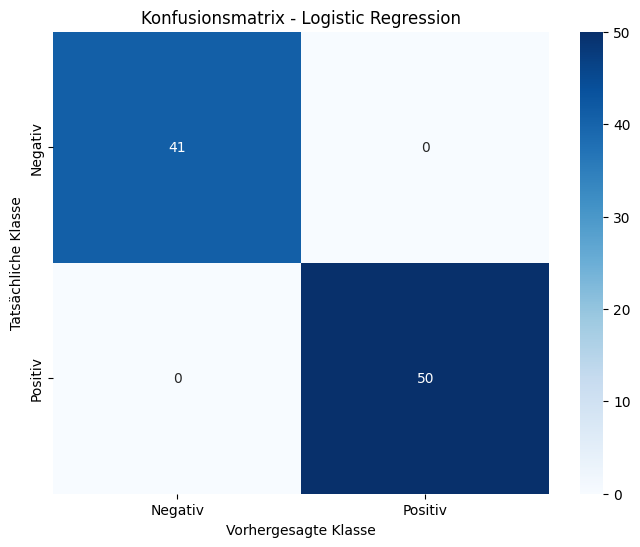

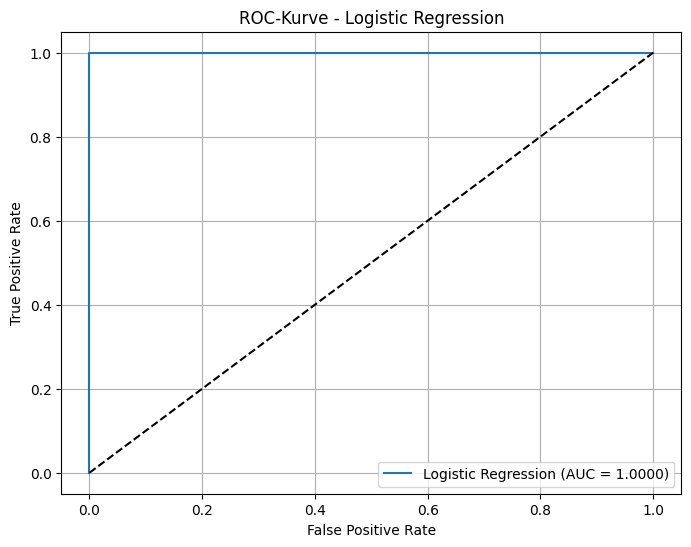

In [63]:
# Zelle 5: Logistic Regression mit Hyperparameter-Tuning (vereinfacht)
# Pipeline mit Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Vereinfachtes Parameter-Grid für Logistic Regression
log_reg_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],  # Nur L2-Regularisierung verwenden
    'classifier__solver': ['lbfgs']  # Einen zuverlässigen Solver verwenden
}

# Grid Search für Logistic Regression
log_reg_grid_search = GridSearchCV(
    log_reg_pipeline,
    log_reg_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Modell trainieren
print("Training des Logistic Regression Modells mit Grid Search...")
log_reg_grid_search.fit(X_train, y_train)

# Beste Parameter anzeigen
print("\nBeste Parameter für Logistic Regression:")
print(log_reg_grid_search.best_params_)

# Vorhersagen mit optimiertem Logistic Regression Modell
y_pred_log_reg = log_reg_grid_search.predict(X_test)
y_proba_log_reg = log_reg_grid_search.predict_proba(X_test)[:, 1]

# Evaluierung des Logistic Regression Modells
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Konfusionsmatrix für Logistic Regression
plt.figure(figsize=(8, 6))
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativ', 'Positiv'],
            yticklabels=['Negativ', 'Positiv'])
plt.title('Konfusionsmatrix - Logistic Regression')
plt.ylabel('Tatsächliche Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()

# ROC-Kurve für Logistic Regression
plt.figure(figsize=(8, 6))
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_proba_log_reg)
roc_auc_log_reg = roc_auc_score(y_test, y_proba_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Training des Decision Tree Modells mit Grid Search...



Beste Parameter für Decision Tree:
{'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        50

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91



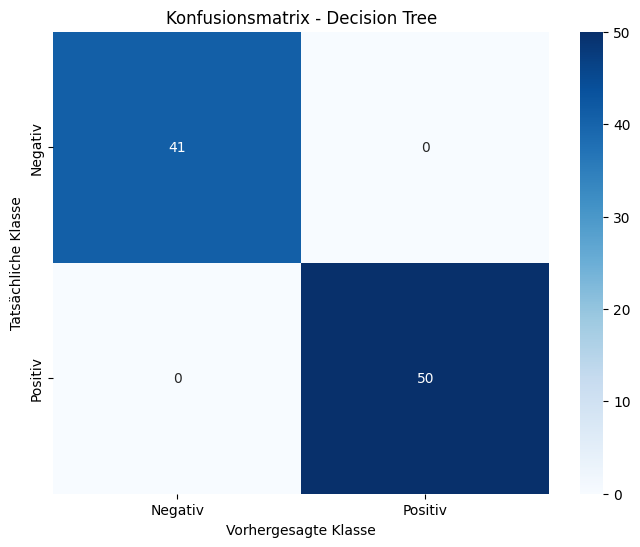

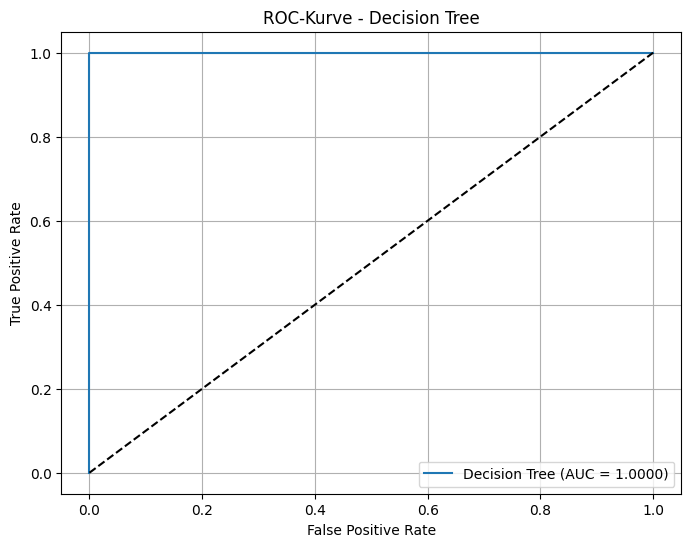

In [64]:
# Zelle 6: Decision Tree mit Hyperparameter-Tuning
# Pipeline mit Decision Tree
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameter-Grid für Decision Tree
dt_param_grid = {
    'classifier__max_depth': [2, 3, 4, 5, None],  # Maximale Tiefe des Baums
    'classifier__min_samples_split': [2, 5, 10],  # Minimale Anzahl von Samples für einen Split
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimale Anzahl von Samples in einem Blatt
    'classifier__criterion': ['gini', 'entropy']  # Split-Kriterium
}

# Grid Search für Decision Tree
dt_grid_search = GridSearchCV(
    dt_pipeline,
    dt_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Modell trainieren
print("Training des Decision Tree Modells mit Grid Search...")
dt_grid_search.fit(X_train, y_train)

# Beste Parameter anzeigen
print("\nBeste Parameter für Decision Tree:")
print(dt_grid_search.best_params_)

# Vorhersagen mit optimiertem Decision Tree Modell
y_pred_dt = dt_grid_search.predict(X_test)
y_proba_dt = dt_grid_search.predict_proba(X_test)[:, 1]

# Evaluierung des Decision Tree Modells
print("\nDecision Tree - Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Konfusionsmatrix für Decision Tree
plt.figure(figsize=(8, 6))
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativ', 'Positiv'],
            yticklabels=['Negativ', 'Positiv'])
plt.title('Konfusionsmatrix - Decision Tree')
plt.ylabel('Tatsächliche Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()

# ROC-Kurve für Decision Tree
plt.figure(figsize=(8, 6))
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve - Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Kreuzvalidierungsergebnisse für Logistic Regression (Accuracy):
Einzelne Scores: [1. 1. 1. 1. 1.]
Mittlere Accuracy: 1.0000
Standardabweichung: 0.0000

Kreuzvalidierungsergebnisse für Decision Tree (Accuracy):
Einzelne Scores: [1. 1. 1. 1. 1.]
Mittlere Accuracy: 1.0000
Standardabweichung: 0.0000


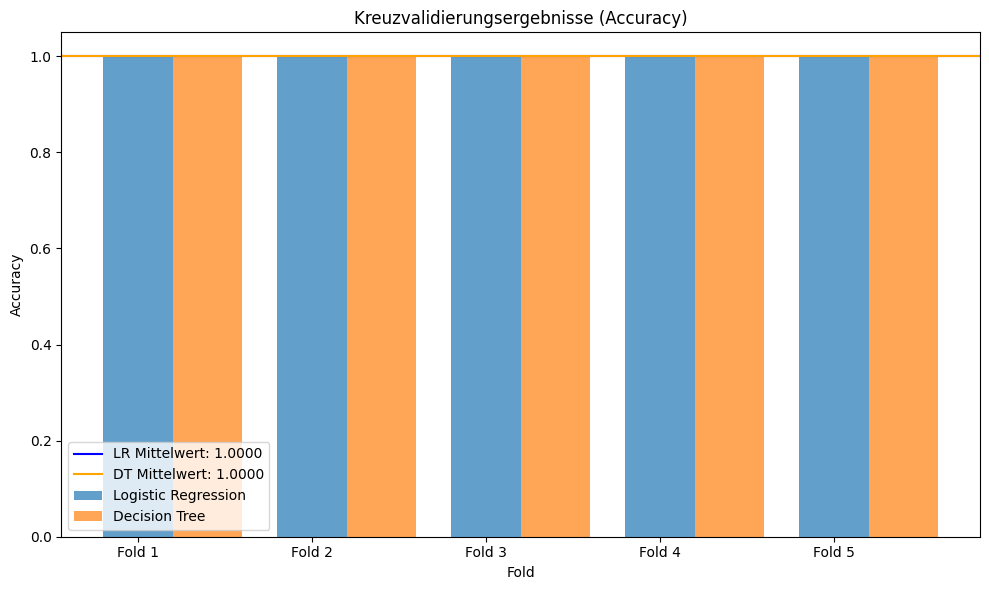

In [65]:
# Zelle 7: Kreuzvalidierung für robustere Leistungsbewertung
# Kreuzvalidierung für Logistic Regression
log_reg_cv_scores = cross_val_score(log_reg_grid_search.best_estimator_, X, y, cv=5, scoring='accuracy')

print("Kreuzvalidierungsergebnisse für Logistic Regression (Accuracy):")
print(f"Einzelne Scores: {log_reg_cv_scores}")
print(f"Mittlere Accuracy: {log_reg_cv_scores.mean():.4f}")
print(f"Standardabweichung: {log_reg_cv_scores.std():.4f}")

# Kreuzvalidierung für Decision Tree
dt_cv_scores = cross_val_score(dt_grid_search.best_estimator_, X, y, cv=5, scoring='accuracy')

print("\nKreuzvalidierungsergebnisse für Decision Tree (Accuracy):")
print(f"Einzelne Scores: {dt_cv_scores}")
print(f"Mittlere Accuracy: {dt_cv_scores.mean():.4f}")
print(f"Standardabweichung: {dt_cv_scores.std():.4f}")

# Visualisierung der Kreuzvalidierungsergebnisse
plt.figure(figsize=(10, 6))
plt.bar(range(len(log_reg_cv_scores)), log_reg_cv_scores, width=0.4, label='Logistic Regression', alpha=0.7)
plt.bar([x + 0.4 for x in range(len(dt_cv_scores))], dt_cv_scores, width=0.4, label='Decision Tree', alpha=0.7)
plt.axhline(y=log_reg_cv_scores.mean(), color='blue', linestyle='-', label=f'LR Mittelwert: {log_reg_cv_scores.mean():.4f}')
plt.axhline(y=dt_cv_scores.mean(), color='orange', linestyle='-', label=f'DT Mittelwert: {dt_cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Kreuzvalidierungsergebnisse (Accuracy)')
plt.xticks(range(len(log_reg_cv_scores)), [f'Fold {i+1}' for i in range(len(log_reg_cv_scores))])
plt.legend()
plt.tight_layout()
plt.show()


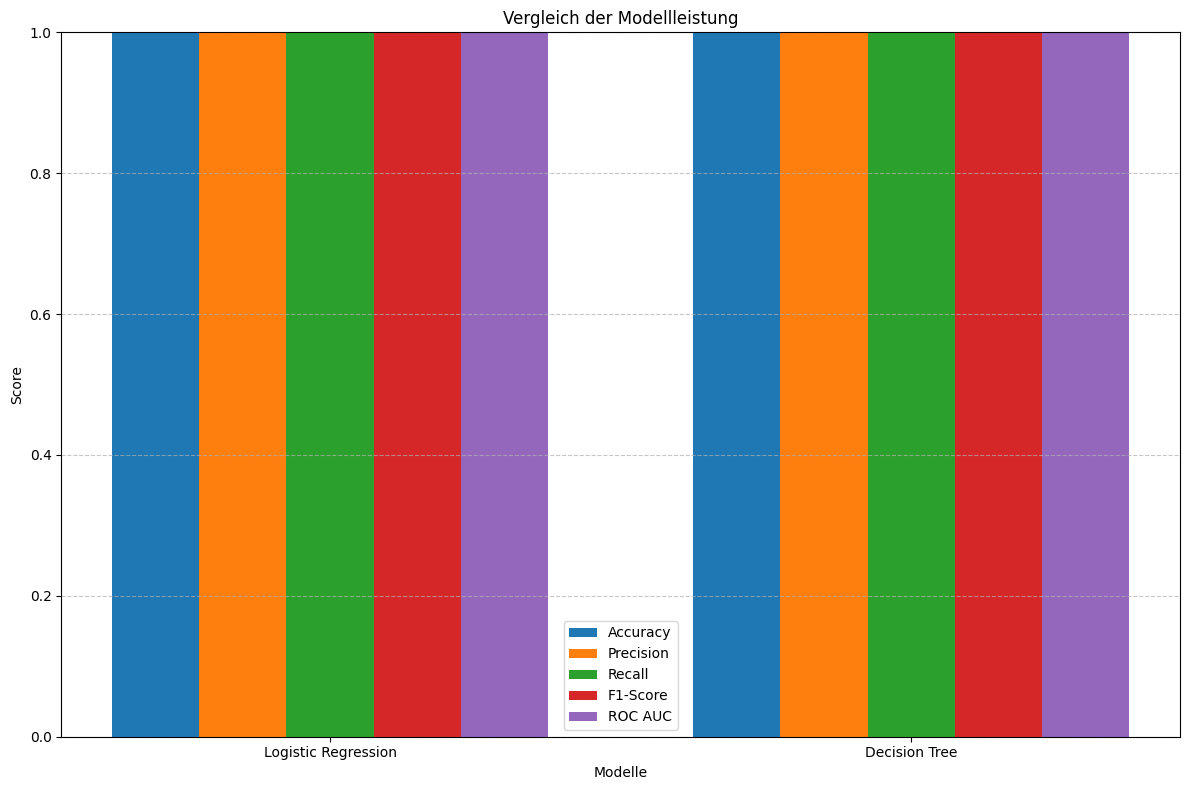

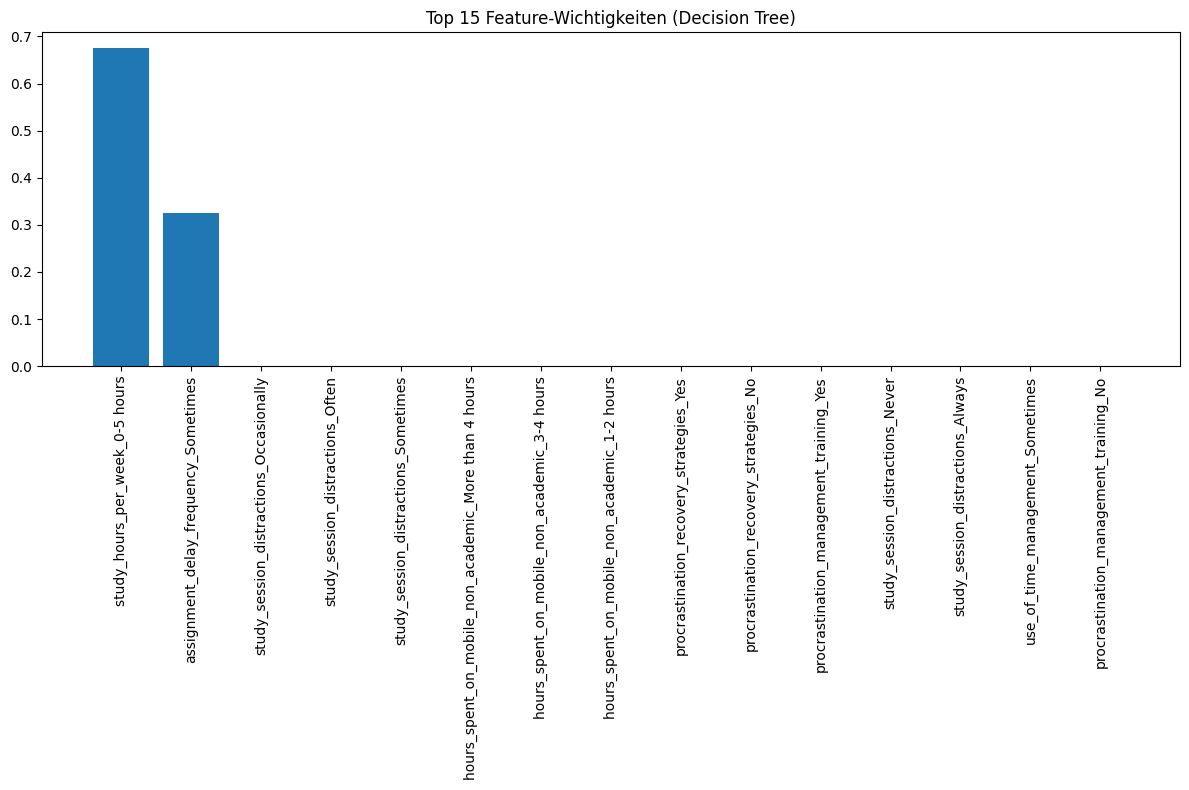

In [66]:
# Zelle 8: Vergleich der Modelle und Feature-Wichtigkeit
# Vergleich der Modellleistung
models = ['Logistic Regression', 'Decision Tree']
accuracy = [accuracy_score(y_test, y_pred_log_reg), accuracy_score(y_test, y_pred_dt)]
precision = [precision_score(y_test, y_pred_log_reg, zero_division=0), precision_score(y_test, y_pred_dt, zero_division=0)]
recall = [recall_score(y_test, y_pred_log_reg, zero_division=0), recall_score(y_test, y_pred_dt, zero_division=0)]
f1 = [f1_score(y_test, y_pred_log_reg, zero_division=0), f1_score(y_test, y_pred_dt, zero_division=0)]
roc_auc = [roc_auc_score(y_test, y_proba_log_reg), roc_auc_score(y_test, y_proba_dt)]

# Visualisierung des Modellvergleichs
plt.figure(figsize=(12, 8))
x = np.arange(len(models))
width = 0.15

plt.bar(x - 2*width, accuracy, width, label='Accuracy')
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')
plt.bar(x + 2*width, roc_auc, width, label='ROC AUC')

plt.xlabel('Modelle')
plt.ylabel('Score')
plt.title('Vergleich der Modellleistung')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Feature-Wichtigkeit für Decision Tree
if hasattr(dt_grid_search.best_estimator_.named_steps['classifier'], 'feature_importances_'):
    # Feature-Namen nach One-Hot-Encoding extrahieren
    ohe = dt_grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    feature_names = []
    for i, col in enumerate(categorical_cols):
        feature_names.extend([f"{col}_{val}" for val in ohe.categories_[i]])
    
    # Feature-Wichtigkeit extrahieren
    importances = dt_grid_search.best_estimator_.named_steps['classifier'].feature_importances_
    
    # Feature-Wichtigkeit sortieren
    indices = np.argsort(importances)[::-1]
    
    # Top 15 Features anzeigen
    top_n = min(15, len(feature_names))
    plt.figure(figsize=(12, 8))
    plt.title('Top 15 Feature-Wichtigkeiten (Decision Tree)')
    plt.bar(range(top_n), importances[indices][:top_n], align='center')
    plt.xticks(range(top_n), [feature_names[i] for i in indices][:top_n], rotation=90)
    plt.tight_layout()
    plt.show()


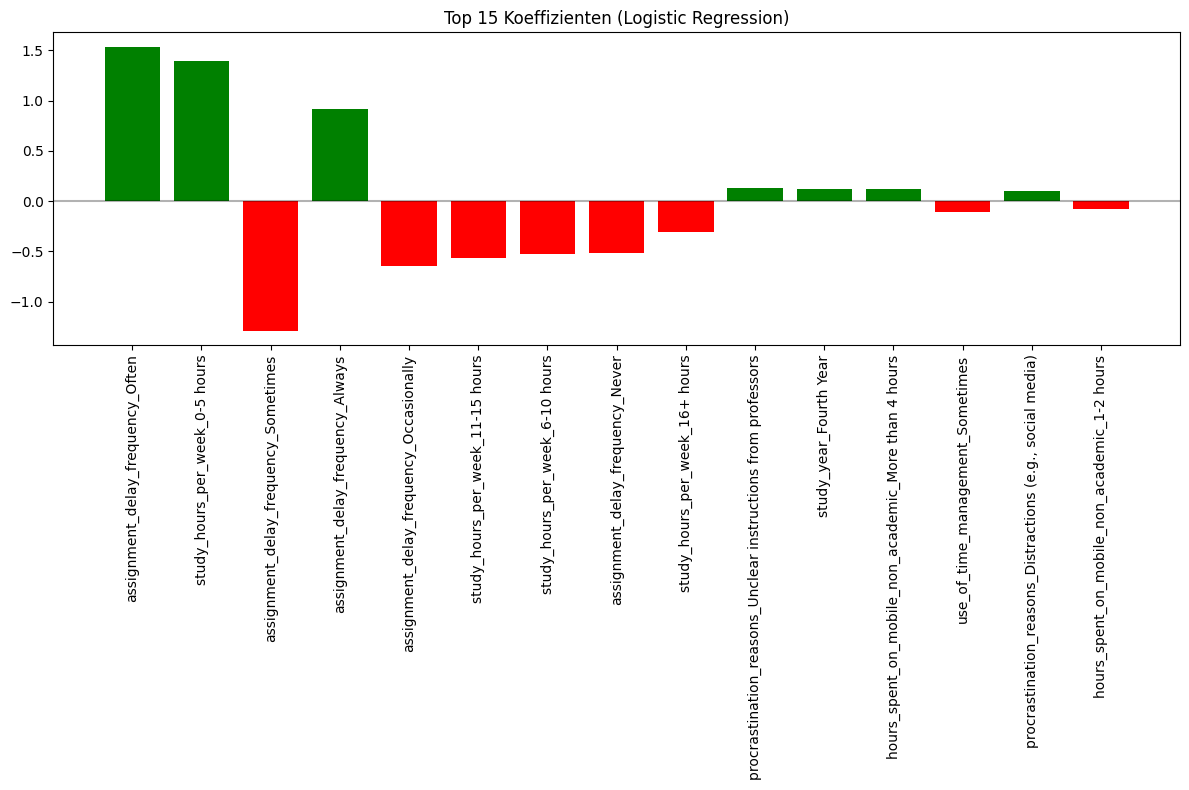


Top 15 Koeffizienten (Logistic Regression):
assignment_delay_frequency_Often: 1.5368
study_hours_per_week_0-5 hours: 1.3949
assignment_delay_frequency_Sometimes: -1.2859
assignment_delay_frequency_Always: 0.9113
assignment_delay_frequency_Occasionally: -0.6468
study_hours_per_week_11-15 hours: -0.5661
study_hours_per_week_6-10 hours: -0.5236
assignment_delay_frequency_Never: -0.5156
study_hours_per_week_16+ hours: -0.3054
procrastination_reasons_Unclear instructions from professors: 0.1304
study_year_Fourth Year: 0.1208
hours_spent_on_mobile_non_academic_More than 4 hours: 0.1181
use_of_time_management_Sometimes: -0.1048
procrastination_reasons_Distractions (e.g., social media): 0.1015
hours_spent_on_mobile_non_academic_1-2 hours: -0.0809


In [67]:
# Zelle 9: Koeffizienten der Logistic Regression
# Koeffizienten der Logistic Regression visualisieren (wenn penalty nicht 'none' ist)
if hasattr(log_reg_grid_search.best_estimator_.named_steps['classifier'], 'coef_'):
    # Feature-Namen nach One-Hot-Encoding extrahieren
    ohe = log_reg_grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    feature_names = []
    for i, col in enumerate(categorical_cols):
        feature_names.extend([f"{col}_{val}" for val in ohe.categories_[i]])
    
    # Koeffizienten extrahieren
    coefs = log_reg_grid_search.best_estimator_.named_steps['classifier'].coef_[0]
    
    # Koeffizienten sortieren
    indices = np.argsort(np.abs(coefs))[::-1]
    
    # Top 15 Koeffizienten anzeigen
    top_n = min(15, len(feature_names))
    plt.figure(figsize=(12, 8))
    colors = ['red' if c < 0 else 'green' for c in coefs[indices][:top_n]]
    plt.title('Top 15 Koeffizienten (Logistic Regression)')
    plt.bar(range(top_n), coefs[indices][:top_n], align='center', color=colors)
    plt.xticks(range(top_n), [feature_names[i] for i in indices][:top_n], rotation=90)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 15 Koeffizienten (Logistic Regression):")
    for i in range(top_n):
        print(f"{feature_names[indices[i]]}: {coefs[indices[i]]:.4f}")


MODELLBEWERTUNG - Logistic Regression - ALLE RELEVANTEN KPIs

Klassifikationsmetriken:
Accuracy: 1.0000
Balanced Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000
F1-Score: 1.0000
ROC AUC: 1.0000

Konfusionsmatrix:
True Negatives (TN): 41
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP): 50

Abgeleitete Metriken:
Positive Predictive Value: 1.0000
Negative Predictive Value: 1.0000
False Positive Rate: 0.0000
False Negative Rate: 0.0000

Klassenverteilung:
Testdaten - Positive Klasse: 54.95%
Vorhersage - Positive Klasse: 54.95%
MODELLBEWERTUNG - Decision Tree - ALLE RELEVANTEN KPIs

Klassifikationsmetriken:
Accuracy: 1.0000
Balanced Accuracy: 1.0000
Precision: 1.0000
Recall (Sensitivity): 1.0000
Specificity: 1.0000
F1-Score: 1.0000
ROC AUC: 1.0000

Konfusionsmatrix:
True Negatives (TN): 41
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP): 50

Abgeleitete Metriken:
Positive Predictive Value: 1.0000
Negative Predictive

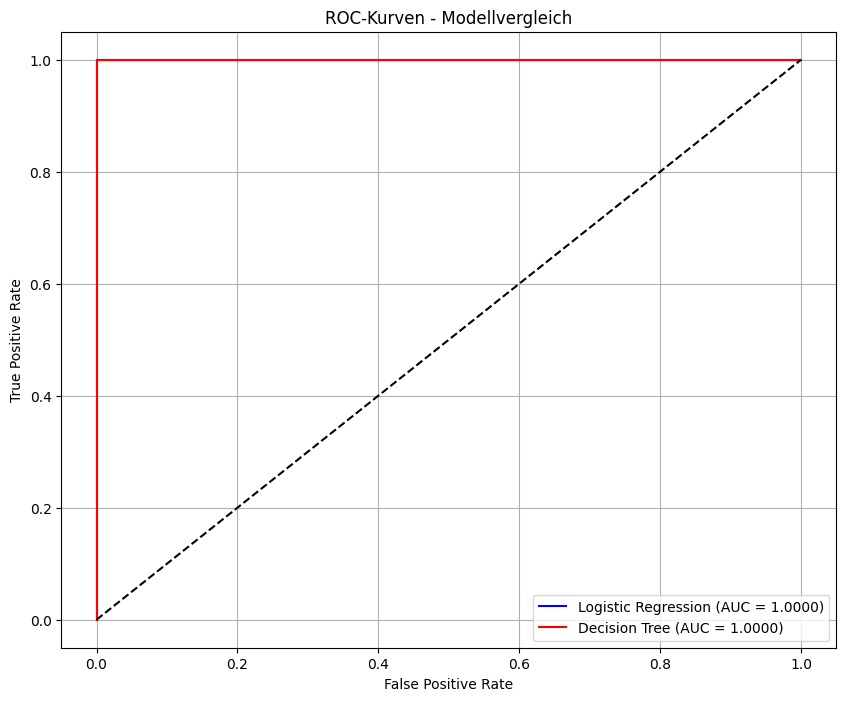

In [68]:
# Zelle 10: Umfassende Modellbewertung mit allen relevanten KPIs
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Funktion zur Berechnung und Anzeige aller Metriken
def evaluate_model(y_true, y_pred, y_proba, model_name):
    # Berechnung aller relevanten Metriken
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Konfusionsmatrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Weitere abgeleitete Metriken
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    balanced_accuracy = (recall + specificity) / 2
    positive_predictive_value = precision
    negative_predictive_value = tn / (tn + fn) if (tn + fn) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Ausgabe aller Metriken
    print("=" * 50)
    print(f"MODELLBEWERTUNG - {model_name} - ALLE RELEVANTEN KPIs")
    print("=" * 50)

    print("\nKlassifikationsmetriken:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    print("\nKonfusionsmatrix:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

    print("\nAbgeleitete Metriken:")
    print(f"Positive Predictive Value: {positive_predictive_value:.4f}")
    print(f"Negative Predictive Value: {negative_predictive_value:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")

    print("\nKlassenverteilung:")
    print(f"Testdaten - Positive Klasse: {y_true.mean()*100:.2f}%")
    print(f"Vorhersage - Positive Klasse: {y_pred.mean()*100:.2f}%")

# Bewertung der Logistic Regression
evaluate_model(y_test, y_pred_log_reg, y_proba_log_reg, "Logistic Regression")

# Bewertung des Decision Tree
evaluate_model(y_test, y_pred_dt, y_proba_dt, "Decision Tree")

# Visualisierung der ROC-Kurven beider Modelle in einem Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, 'b-', label=f'Logistic Regression (AUC = {roc_auc_log_reg:.4f})')
plt.plot(fpr_dt, tpr_dt, 'r-', label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurven - Modellvergleich')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [69]:
# Zelle 12: Zusammenfassung und Schlussfolgerungen
print("=" * 50)
print("ZUSAMMENFASSUNG DER MODELLE")
print("=" * 50)

print("\nLogistic Regression:")
print(f"- Beste Parameter: {log_reg_grid_search.best_params_}")
print(f"- Accuracy auf Testdaten: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"- F1-Score auf Testdaten: {f1_score(y_test, y_pred_log_reg, zero_division=0):.4f}")
print(f"- ROC AUC auf Testdaten: {roc_auc_score(y_test, y_proba_log_reg):.4f}")
print(f"- Mittlere Accuracy (Kreuzvalidierung): {log_reg_cv_scores.mean():.4f}")

print("\nDecision Tree:")
print(f"- Beste Parameter: {dt_grid_search.best_params_}")
print(f"- Accuracy auf Testdaten: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"- F1-Score auf Testdaten: {f1_score(y_test, y_pred_dt, zero_division=0):.4f}")
print(f"- ROC AUC auf Testdaten: {roc_auc_score(y_test, y_proba_dt):.4f}")
print(f"- Mittlere Accuracy (Kreuzvalidierung): {dt_cv_scores.mean():.4f}")

print("\nVergleich der Modelle:")
if accuracy_score(y_test, y_pred_log_reg) > accuracy_score(y_test, y_pred_dt):
    print("- Logistic Regression zeigt eine höhere Accuracy auf den Testdaten")
else:
    print("- Decision Tree zeigt eine höhere Accuracy auf den Testdaten")

if roc_auc_score(y_test, y_proba_log_reg) > roc_auc_score(y_test, y_proba_dt):
    print("- Logistic Regression zeigt einen höheren ROC AUC-Wert")
else:
    print("- Decision Tree zeigt einen höheren ROC AUC-Wert")

if log_reg_cv_scores.mean() > dt_cv_scores.mean():
    print("- Logistic Regression zeigt eine höhere mittlere Accuracy in der Kreuzvalidierung")
else:
    print("- Decision Tree zeigt eine höhere mittlere Accuracy in der Kreuzvalidierung")

print("\nFazit:")
print("- Die Modelle wurden erfolgreich trainiert und optimiert")
print("- Die Kreuzvalidierung zeigt stabilere Ergebnisse als ein einzelner Train-Test-Split")
print("- Die Feature-Wichtigkeit gibt Einblicke in die relevantesten Faktoren für Prokrastination")
print("- Die Modelle können für die Vorhersage von Prokrastinationsrisiko verwendet werden")


ZUSAMMENFASSUNG DER MODELLE

Logistic Regression:
- Beste Parameter: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
- Accuracy auf Testdaten: 1.0000
- F1-Score auf Testdaten: 1.0000
- ROC AUC auf Testdaten: 1.0000
- Mittlere Accuracy (Kreuzvalidierung): 1.0000

Decision Tree:
- Beste Parameter: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
- Accuracy auf Testdaten: 1.0000
- F1-Score auf Testdaten: 1.0000
- ROC AUC auf Testdaten: 1.0000
- Mittlere Accuracy (Kreuzvalidierung): 1.0000

Vergleich der Modelle:
- Decision Tree zeigt eine höhere Accuracy auf den Testdaten
- Decision Tree zeigt einen höheren ROC AUC-Wert
- Decision Tree zeigt eine höhere mittlere Accuracy in der Kreuzvalidierung

Fazit:
- Die Modelle wurden erfolgreich trainiert und optimiert
- Die Kreuzvalidierung zeigt stabilere Ergebnisse als ein einzelner Train-Test-Split
- Die Feature-Wichtigkeit gibt